In [1]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xgboost as xgb

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
plt.style.use('default')

Load training data

In [2]:
df = pd.read_csv('wfdata.csv', index_col=0)
feature_cols = [n for n in df.columns if n not in ('name', 'label')]

X = df[feature_cols].values
Y = df['label']
X_train_val, X_test, Y_train_val, Y_test = train_test_split(X, Y, test_size=0.2, random_state=7)

trainValDf = pd.DataFrame(X_train_val, columns=feature_cols)
testDf = pd.DataFrame(X_test, columns=feature_cols)

xg_train = xgb.DMatrix(trainValDf, label=Y_train_val)
xg_test = xgb.DMatrix(X_test, label=Y_test)

In [3]:
print("Total records:", len(df.index))
print(f"Unique workflows: {len(df['name'].unique())}")
print("Records ratio by label:", np.unique(df['label'], return_counts=True))
print("Features:", len(feature_cols), feature_cols)

Total records: 695029
Unique workflows: 3252
Records ratio by label: (array([0, 1, 2]), array([346256, 271147,  77626]))
Features: 19 ['failureRate', 'totalError', 'sites_siteCounts', 'type', 'sites_errorPerSite_max', 'sites_errorPerSite_min', 'sites_errorPerSite_median', 'sites_errorPerSite_mean', 'sites_errorPerSite_stdDev', 'errorCode_primary_multiplicity', 'errorCode_primary_leadingCode', 'errorCode_primary_leadingRatio', 'errorCode_secondary_multiplicity', 'errorCode_secondary_leadingCode', 'errorCode_secondary_leadingRatio', 'errorKeywords_multiplicity', 'errorKeywords_leading', 'errorKeywords_leadingRatio', 'time_sinceOpenInHour']


## initial parameters

In [4]:
def modelfit(algo, trainDf, label, useTrainCV=True, cv_folds=3, early_stopping_rounds=20):
    eval_history = None
    if useTrainCV:
        xgb_param = algo.get_xgb_params()
        dtrain = xgb.DMatrix(trainDf, label=label)
        cvresult = xgb.cv(
            xgb_param, dtrain,
            metrics=['merror'],
            num_boost_round=algo.get_params()['n_estimators'],
            nfold=cv_folds,
            early_stopping_rounds=early_stopping_rounds,
            verbose_eval=50
        )
        print("n_estimator found by cv:", cvresult.shape[0])
        algo.set_params(n_estimators=cvresult.shape[0])
        eval_history = cvresult
        
    # fit algorithm on data
    algo.fit(trainDf, label, eval_metric='auc')
    #predict training set
    y_predictions = algo.predict(trainDf)
    y_predprob = algo.predict_proba(trainDf)[:, 1]

    # print model report
    print("\nModel Report")
    print("Accuracy: {:.4g}".format(accuracy_score(label, y_predictions)))
    target_names = ['good', 'site-issue', 'workflow-issue']
    print(classification_report(label, y_predictions, target_names=target_names))

    xgb.plot_importance(algo.get_booster(), height=0.8)

    return eval_history

{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bynode': 1, 'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.05, 'max_delta_step': 0, 'max_depth': 18, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1000, 'n_jobs': 1, 'nthread': 16, 'objective': 'multi:softprob', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 1, 'scale_pos_weight': 1, 'seed': 27, 'silent': None, 'subsample': 0.8, 'verbosity': 1, 'num_class': 3, 'tree_method': 'gpu_hist'}
[0]	train-merror:0.040039+0.00221856	test-merror:0.044351+0.00169462
[50]	train-merror:0.0210963+0.000190729	test-merror:0.0248587+0.000544493
[100]	train-merror:0.017256+0.00021506	test-merror:0.0218173+0.000427871
[150]	train-merror:0.013844+0.000133734	test-merror:0.019197+0.000319509
[200]	train-merror:0.0122307+9.2435e-05	test-merror:0.018188+0.000362227
[250]	train-merror:0.0113963+9.55487e-05	test-merror:0.017839+0.000307711
[300]	train-merror:0.010925+0.000106069	test-merror:0.0175873+0.000320419
n_e

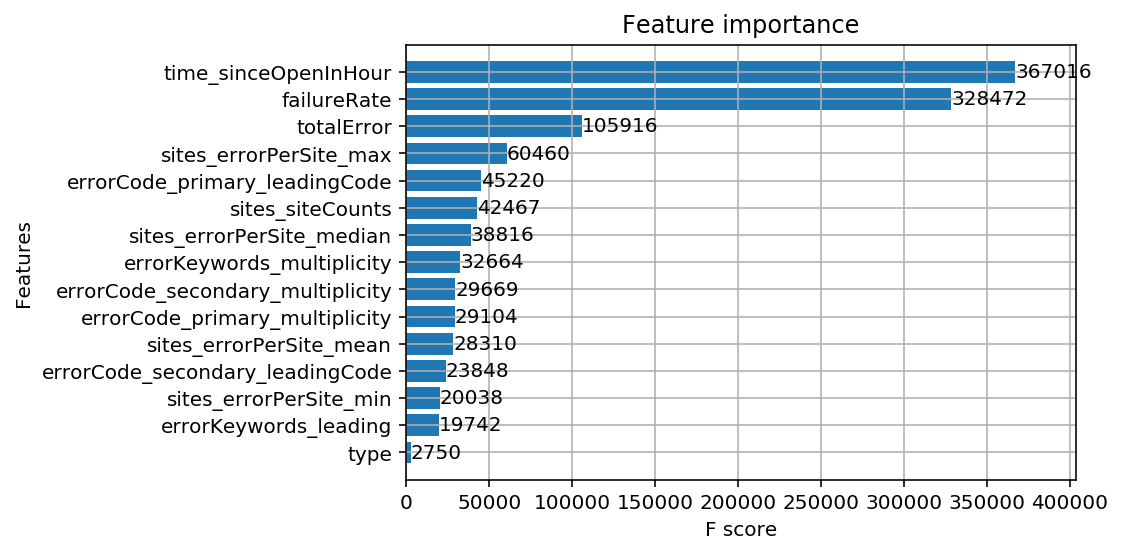

In [5]:
xgb1 = xgb.XGBClassifier(
    learning_rate=0.05,
    n_estimators=1000,
    max_depth=18,
    min_child_weight=1,
    gamma=0,
    subsample=0.8,
    colsample_bytree=0.8,
    objective='multi:softprob',
    nthread=16,
    scale_pos_weight=1,
    seed=27,
    num_class=3,
    tree_method='gpu_hist',
)
print(xgb1.get_params())
history = modelfit(xgb1, pd.DataFrame(X_train_val, columns=feature_cols), Y_train_val)

In [6]:
test_predictions = xgb1.predict(testDf)
test_predprob = xgb1.predict_proba(testDf)[:,1]
print("Accuracy: {:.4g}".format(accuracy_score(Y_test, test_predictions)))
target_names = ['good', 'site-issue', 'workflow-issue']
print(classification_report(Y_test, test_predictions, target_names=target_names))

Accuracy: 0.9834
                precision    recall  f1-score   support

          good       0.98      0.99      0.99     69429
    site-issue       0.99      0.98      0.99     54275
workflow-issue       0.97      0.96      0.97     15302

      accuracy                           0.98    139006
     macro avg       0.98      0.98      0.98    139006
  weighted avg       0.98      0.98      0.98    139006



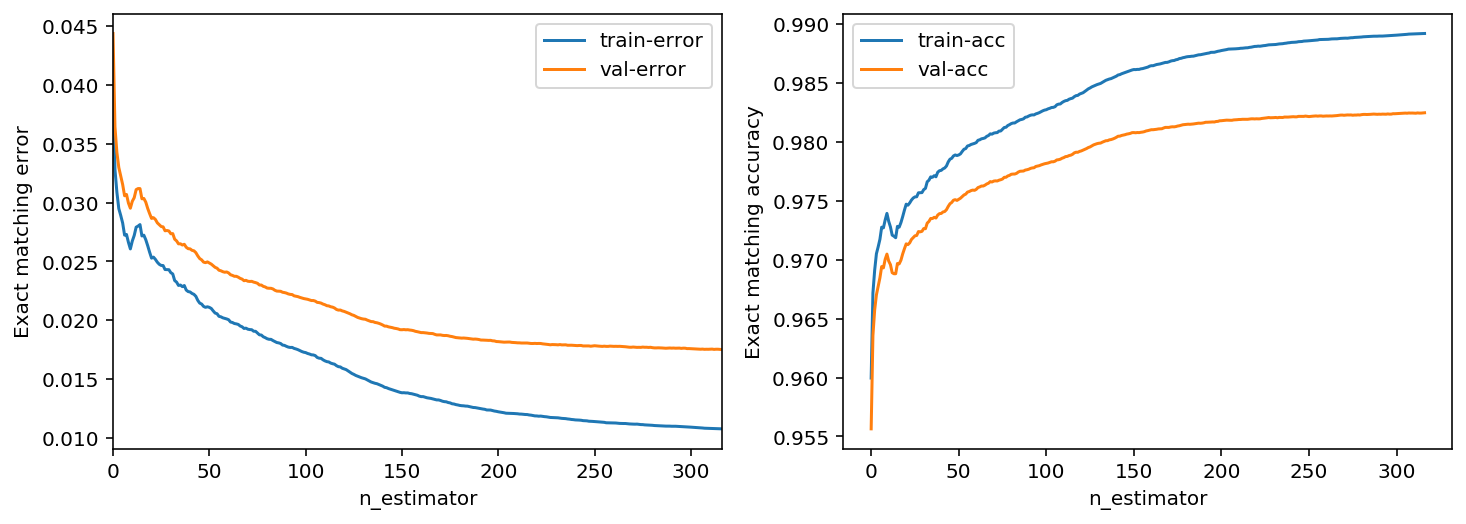

In [7]:
plt.figure(figsize=(12,4))
ax = plt.subplot(1,2,1)
history['train-merror-mean'].plot(label='train-error', ax=ax)
history['test-merror-mean'].plot(label='val-error', ax=ax)
plt.xlabel('n_estimator')
plt.ylabel('Exact matching error')
plt.legend()

ax = plt.subplot(1,2,2)
ax.plot(1-history['train-merror-mean'], label='train-acc')
ax.plot(1-history['test-merror-mean'], label='val-acc')
plt.xlabel('n_estimator')
plt.ylabel('Exact matching accuracy')
plt.legend();

In [8]:
bst1 = xgb1.get_booster()

In [9]:
testworkflows = {i: df.query(f'label=={i}').iloc[0]['name'] for i in range(3)}
for k, v in testworkflows.items(): print(k, v)

0 pdmvserv_task_HIG-RunIIFall17wmLHEGS-03920__v1_T_190516_084611_9112
1 pdmvserv_task_EXO-RunIISummer15wmLHEGS-07026__v1_T_190611_225231_6189
2 pdmvserv_task_HIG-RunIIFall17wmLHEGS-03804__v1_T_190516_002026_8689


In [10]:
for k, wfname in testworkflows.items():
    
    print(f'### {k} - {wfname} ###')
    
    testd = df[df['name']==wfname]
    testX, testy = testd[feature_cols], testd['label']
    testXxg = xgb.DMatrix(testX)
    test_pred_prob = bst1.predict(testXxg).reshape(testy.shape[0], 3)
    test_pred_label= np.argmax(test_pred_prob, axis=1)

    print('true:', testy.values.astype(int))
    print('predict:', test_pred_label)
    print('precision:', '{}/{}'.format((testy.values==test_pred_label).sum(), len(test_pred_label)))
    
    timespan = testd['time_sinceOpenInHour']
    timespan.values.sort()
    print('timespan:', timespan.min(), '-', timespan.max())
    
    print('_'*79, end='\n\n')

### 0 - pdmvserv_task_HIG-RunIIFall17wmLHEGS-03920__v1_T_190516_084611_9112 ###
true: [0 0 0 ... 0 0 0]
predict: [0 0 0 ... 0 0 0]
precision: 1309/1310
timespan: 67.575 - 1257.4252777777776
_______________________________________________________________________________

### 1 - pdmvserv_task_EXO-RunIISummer15wmLHEGS-07026__v1_T_190611_225231_6189 ###
true: [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 

In [11]:
bst1.save_model('xgb_default.model')

## Bayesian optimization on hyperparameters

In [4]:
from skopt.space import Real, Integer
from skopt.utils import use_named_args
from skopt import gp_minimize

space = [
    Real(1e-2, 1, 'log-uniform', name='learning_rate'),
    Integer(0, 10, name='min_child_weight'),
    Integer(2, len(feature_cols), name='max_depth'),
    Real(0.01, 1.0, 'uniform', name='subsample'),
    Real(0.01, 1.0, 'uniform', name='colsample_bytree'),
    Real(1e-6, 1e3, 'log-uniform', name='reg_lambda'),
    Real(1e-6, 1, 'log-uniform', name='reg_alpha'),
    Real(1e-9, 0.5, 'log-uniform', name='gamma'),
    Integer(0, 5, name='min_child_weight'),
    Real(1e-6, 500, 'log-uniform', name='scale_pos_weight'),
]


@use_named_args(space)
def objective(**X):
    print("New configuration: {}".format(X))
    
    model = xgb.XGBClassifier(objective='multi:softprob',tree_method='gpu_hist',silent=False,
                              nthread=16, seed=32, num_class=3, **X)
    cvresult = xgb.cv(model.get_params(),
                      xg_train,
                      metrics=['merror'],
                      num_boost_round=1000,
                      nfold=5,
                      early_stopping_rounds=25,
                      verbose_eval=50,
                     )
    model.set_params(n_estimators=cvresult.shape[0])

    return cvresult['test-merror-mean'].min()

/uscms/home/wsi/nobackup/miniconda3/envs/osdroid/lib/python3.7/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


In [5]:
search_result = gp_minimize(func=objective,
                            dimensions=space,
                            acq_func='EI',
                            n_calls=50,
                            n_random_starts=3,
                            verbose=True,
                           )

Iteration No: 1 started. Evaluating function at random point.
New configuration: {'learning_rate': 0.0666215929271889, 'min_child_weight': 2, 'max_depth': 11, 'subsample': 0.4098623177297294, 'colsample_bytree': 0.9074434552837584, 'reg_lambda': 0.00012909431716297954, 'reg_alpha': 0.0011873489991476216, 'gamma': 3.9358026291015275e-05, 'scale_pos_weight': 16.221552127291687}
[0]	train-merror:0.164255+0.00761592	test-merror:0.165562+0.00798437
[50]	train-merror:0.0762892+0.000976572	test-merror:0.0780364+0.00206768
[100]	train-merror:0.0486766+0.000658873	test-merror:0.0506456+0.00176557
[150]	train-merror:0.02994+0.000530681	test-merror:0.0324556+0.00116078
[200]	train-merror:0.0219866+0.000146797	test-merror:0.0250636+0.000852598
[250]	train-merror:0.0185086+9.59971e-05	test-merror:0.0221284+0.00049257
[300]	train-merror:0.0165486+0.000122751	test-merror:0.0205856+0.000479497
[350]	train-merror:0.0153032+0.000126153	test-merror:0.0197958+0.000447103
[400]	train-merror:0.0144136+0.000

[0]	train-merror:0.189546+0.00376429	test-merror:0.191053+0.00509174
[50]	train-merror:0.139845+0.00110331	test-merror:0.140951+0.00162998
[100]	train-merror:0.128828+0.000857835	test-merror:0.129939+0.00237705
[150]	train-merror:0.11971+0.00101689	test-merror:0.120786+0.00228326
[200]	train-merror:0.11039+0.000457991	test-merror:0.111395+0.00185959
[250]	train-merror:0.104165+0.000543608	test-merror:0.105222+0.00189307
[300]	train-merror:0.0985486+0.000369495	test-merror:0.0998054+0.0016789
[350]	train-merror:0.0942452+0.000378765	test-merror:0.0955482+0.00105985
[400]	train-merror:0.0904278+0.000383498	test-merror:0.0917046+0.000896811
[450]	train-merror:0.0870292+0.000332227	test-merror:0.0882822+0.000950614
[500]	train-merror:0.0840782+0.000417237	test-merror:0.085342+0.000777593
[550]	train-merror:0.0807528+0.000268626	test-merror:0.0820632+0.00104038
[600]	train-merror:0.0777192+0.000337199	test-merror:0.0789808+0.00102314
[650]	train-merror:0.0742146+0.000200035	test-merror:0.07

[400]	train-merror:0.0538968+0.00151443	test-merror:0.055886+0.000389175
[450]	train-merror:0.0514516+0.000995664	test-merror:0.0535444+0.000405748
[500]	train-merror:0.0496508+0.000736207	test-merror:0.051773+0.000556876
[550]	train-merror:0.047856+0.000563157	test-merror:0.04989+0.000964565
[600]	train-merror:0.0454524+0.000283016	test-merror:0.047545+0.00114205
[650]	train-merror:0.0430334+0.000443609	test-merror:0.0452734+0.000828321
[700]	train-merror:0.0405784+0.000896902	test-merror:0.0429226+0.000883397
[750]	train-merror:0.0370798+0.000824772	test-merror:0.0396782+0.000705961
[800]	train-merror:0.0344744+0.000880599	test-merror:0.0370002+0.00041714
[850]	train-merror:0.0325938+0.00108534	test-merror:0.0351244+0.000556175
[900]	train-merror:0.0303708+0.000714115	test-merror:0.0329248+0.000246497
[950]	train-merror:0.0286548+0.000656184	test-merror:0.0312864+0.000400187
[999]	train-merror:0.0272756+0.000840596	test-merror:0.0300076+0.000706374
Iteration No: 11 ended. Search fini

[250]	train-merror:0.173607+0.00191667	test-merror:0.174646+0.00204911
[300]	train-merror:0.164138+0.000892497	test-merror:0.165438+0.00158838
[350]	train-merror:0.156366+0.00125757	test-merror:0.157565+0.00208748
[400]	train-merror:0.150546+0.000903723	test-merror:0.151783+0.00214978
[450]	train-merror:0.144771+0.000884201	test-merror:0.146307+0.00181664
[500]	train-merror:0.14037+0.000657918	test-merror:0.141732+0.00156378
[550]	train-merror:0.136274+0.000577789	test-merror:0.137541+0.00163324
[600]	train-merror:0.132238+0.000490835	test-merror:0.133599+0.00162737
[650]	train-merror:0.129006+0.000668624	test-merror:0.13027+0.00189853
[700]	train-merror:0.125792+0.000458475	test-merror:0.127137+0.00172882
[750]	train-merror:0.122221+0.000396064	test-merror:0.12356+0.00162865
[800]	train-merror:0.12013+0.00062316	test-merror:0.121401+0.0019619
[850]	train-merror:0.117562+0.0007151	test-merror:0.118761+0.00201012
[900]	train-merror:0.114851+0.000468392	test-merror:0.116348+0.0015707
[95

[900]	train-merror:0.132278+0.0580908	test-merror:0.133236+0.0572035
[950]	train-merror:0.130537+0.0589632	test-merror:0.131703+0.0579695
[999]	train-merror:0.128987+0.0597339	test-merror:0.130313+0.0586633
Iteration No: 21 ended. Search finished for the next optimal point.
Time taken: 108.2890
Function value obtained: 0.1303
Current minimum: 0.0174
Iteration No: 22 started. Searching for the next optimal point.
New configuration: {'learning_rate': 1.0, 'min_child_weight': 5, 'max_depth': 19, 'subsample': 1.0, 'colsample_bytree': 0.26873943490660646, 'reg_lambda': 1000.0, 'reg_alpha': 1e-06, 'gamma': 0.007239010725024209, 'scale_pos_weight': 1e-06}
[0]	train-merror:0.335282+0.00100406	test-merror:0.335456+0.00173005
[50]	train-merror:0.0518948+0.000339463	test-merror:0.0543288+0.00132483
[100]	train-merror:0.039325+0.000347684	test-merror:0.0420612+0.00104695
[150]	train-merror:0.0336502+0.000339596	test-merror:0.0366156+0.000815034
[200]	train-merror:0.0303226+0.000294509	test-merror:

[100]	train-merror:0.0107464+9.88728e-05	test-merror:0.017555+0.000353116
[150]	train-merror:0.0105638+0.000110913	test-merror:0.0173914+0.000304195
Iteration No: 27 ended. Search finished for the next optimal point.
Time taken: 131.3013
Function value obtained: 0.0174
Current minimum: 0.0174
Iteration No: 28 started. Searching for the next optimal point.
New configuration: {'learning_rate': 1.0, 'min_child_weight': 4, 'max_depth': 19, 'subsample': 1.0, 'colsample_bytree': 0.5493412630639459, 'reg_lambda': 1e-06, 'reg_alpha': 1e-06, 'gamma': 0.49999999999999994, 'scale_pos_weight': 1e-06}
[0]	train-merror:0.0747364+0.000892412	test-merror:0.0803292+0.0018364
[50]	train-merror:0.0113474+0.000122209	test-merror:0.017751+0.000340956
[100]	train-merror:0.010779+7.44392e-05	test-merror:0.0175568+0.000288094
Iteration No: 28 ended. Search finished for the next optimal point.
Time taken: 107.1456
Function value obtained: 0.0175
Current minimum: 0.0174
Iteration No: 29 started. Searching for t

[50]	train-merror:0.286993+0.00292114	test-merror:0.288191+0.0028369
[100]	train-merror:0.277863+0.00284741	test-merror:0.278945+0.00329816
[150]	train-merror:0.273718+0.00163569	test-merror:0.274706+0.00233918
Iteration No: 37 ended. Search finished for the next optimal point.
Time taken: 36.5155
Function value obtained: 0.2733
Current minimum: 0.0171
Iteration No: 38 started. Searching for the next optimal point.
New configuration: {'learning_rate': 1.0, 'min_child_weight': 5, 'max_depth': 19, 'subsample': 1.0, 'colsample_bytree': 0.4044064861378267, 'reg_lambda': 1e-06, 'reg_alpha': 3.932506258234701e-06, 'gamma': 0.0005391051653640758, 'scale_pos_weight': 8.90437074607901e-06}
[0]	train-merror:0.20419+0.00032868	test-merror:0.210988+0.00179343
[50]	train-merror:0.0122448+0.000151358	test-merror:0.018476+0.000294022
[100]	train-merror:0.0114926+9.31463e-05	test-merror:0.0180224+0.000349652
[150]	train-merror:0.0112422+7.85911e-05	test-merror:0.0178788+0.000306497
Iteration No: 38 en

[550]	train-merror:0.0177898+0.00015904	test-merror:0.0218248+0.000524402
[600]	train-merror:0.0174456+0.000183623	test-merror:0.021535+0.000496267
[650]	train-merror:0.0172246+0.00017059	test-merror:0.021283+0.000404564
[700]	train-merror:0.0169394+0.000165897	test-merror:0.0210622+0.000391443
[750]	train-merror:0.0167826+0.000152285	test-merror:0.020904+0.000370879
[800]	train-merror:0.0165474+0.000110061	test-merror:0.0207206+0.00034094
[850]	train-merror:0.0163118+0.000128783	test-merror:0.0205478+0.000369739
[900]	train-merror:0.0161584+0.000141442	test-merror:0.02042+0.00034247
[950]	train-merror:0.0160146+0.000111955	test-merror:0.0203228+0.000363523
[999]	train-merror:0.0158144+0.000116261	test-merror:0.0201664+0.00028327
Iteration No: 46 ended. Search finished for the next optimal point.
Time taken: 1307.7770
Function value obtained: 0.0201
Current minimum: 0.0171
Iteration No: 47 started. Searching for the next optimal point.
New configuration: {'learning_rate': 1.0, 'min_chi

In [6]:
search_result

          fun: 0.017145
    func_vals: array([0.0177422, 0.0327774, 0.0327774, 0.1726242, 0.1874564, 0.0544094,
       0.0179056, 0.0178212, 0.0183034, 0.0769556, 0.0300076, 0.0217024,
       0.3702492, 0.0821494, 0.051899 , 0.1120368, 0.0291716, 0.0173896,
       0.0903884, 0.0238086, 0.1303128, 0.0233302, 0.0189774, 0.1050406,
       0.0174256, 0.2155898, 0.0173914, 0.0175138, 0.018343 , 0.0177456,
       0.017395 , 0.0171938, 0.018208 , 0.0175264, 0.017145 , 0.0179902,
       0.2733178, 0.0178302, 0.0176164, 0.024402 , 0.0182364, 0.0182528,
       0.0178982, 0.0174922, 0.0177638, 0.0201304, 0.0175064, 0.1080494,
       0.0177924, 0.019751 ])
       models: [GaussianProcessRegressor(alpha=1e-10, copy_X_train=True,
                         kernel=1**2 * Matern(length_scale=[1, 1, 1, 1, 1, 1, 1, 1, 1, 1], nu=2.5) + WhiteKernel(noise_level=1),
                         n_restarts_optimizer=2, noise='gaussian',
                         normalize_y=True, optimizer='fmin_l_bfgs_b',
        

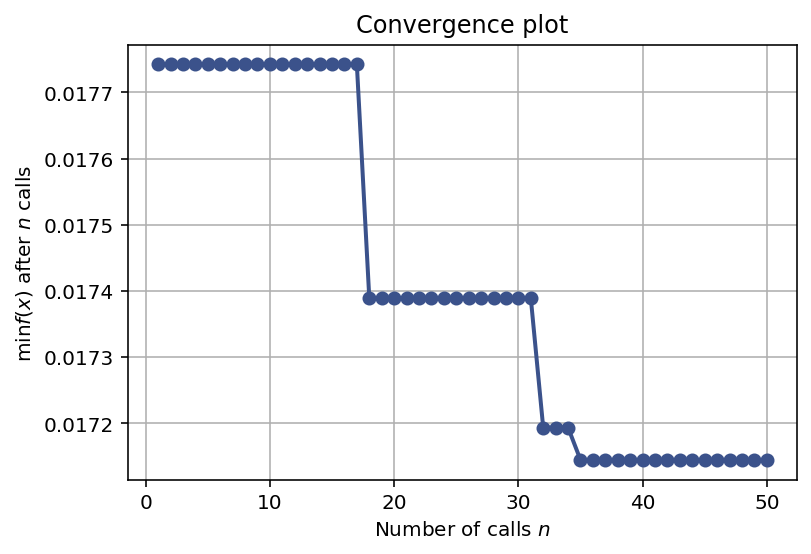

In [7]:
from skopt.plots import plot_convergence
plot_convergence(search_result);

In [9]:
bestParam = dict(zip(
    ['learning_rate', 'min_child_weight', 'max_depth',
     'subsample', 'colsample_bytree', 'reg_lambda', 'reg_alpha',
     'gamma', 'min_child_weight', 'scale_pos_weight'],
    search_result.x))
bestParam

{'learning_rate': 0.01,
 'min_child_weight': 0,
 'max_depth': 19,
 'subsample': 0.589313180124391,
 'colsample_bytree': 1.0,
 'reg_lambda': 1e-06,
 'reg_alpha': 2.8029820894017196e-06,
 'gamma': 0.00017964566660839373,
 'scale_pos_weight': 499.99999999999994}

In [4]:
bestModel = xgb.XGBClassifier(objective='multi:softprob', tree_method='gpu_hist', silent=False,
                              nthread=16, seed=32, num_class=3, **bestParam)
cvresult = xgb.cv(bestModel.get_params(), xg_train,
                  metrics=['merror'],
                  num_boost_round=1000,
                  nfold=5,
                  early_stopping_rounds=25,
                  verbose_eval=50)

bestModel.set_params(n_estimators=cvresult.shape[0])

[0]	train-merror:0.0266674+0.00100501	test-merror:0.0313978+0.00145836
[50]	train-merror:0.0186826+0.000471502	test-merror:0.0229038+0.000777958
[100]	train-merror:0.0175732+0.000378975	test-merror:0.021724+0.000671551
[150]	train-merror:0.016457+0.000240929	test-merror:0.020785+0.000609007
[200]	train-merror:0.0154722+0.00029655	test-merror:0.0200386+0.000667826
[250]	train-merror:0.0147938+0.000322487	test-merror:0.0195836+0.000649324
[300]	train-merror:0.014123+0.000215664	test-merror:0.0190748+0.000555795
[350]	train-merror:0.0134954+0.000165206	test-merror:0.0186414+0.000530595
[400]	train-merror:0.01298+0.000140752	test-merror:0.01817+0.000458483
[450]	train-merror:0.0125786+0.000150585	test-merror:0.0179238+0.000453942
[500]	train-merror:0.0122666+0.000106643	test-merror:0.017681+0.000319994
[550]	train-merror:0.011926+9.12973e-05	test-merror:0.017465+0.000237561
[600]	train-merror:0.0115488+0.000124905	test-merror:0.017278+0.000217782
[650]	train-merror:0.0112594+0.000113697	te

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1.0,
              gamma=0.00017964566660839373, learning_rate=0.01,
              max_delta_step=0, max_depth=19, min_child_weight=0, missing=None,
              n_estimators=685, n_jobs=1, nthread=16, num_class=3,
              objective='multi:softprob', random_state=0,
              reg_alpha=2.8029820894017196e-06, reg_lambda=1e-06,
              scale_pos_weight=499.99999999999994, seed=32, silent=False,
              subsample=0.589313180124391, tree_method='gpu_hist', verbosity=1)

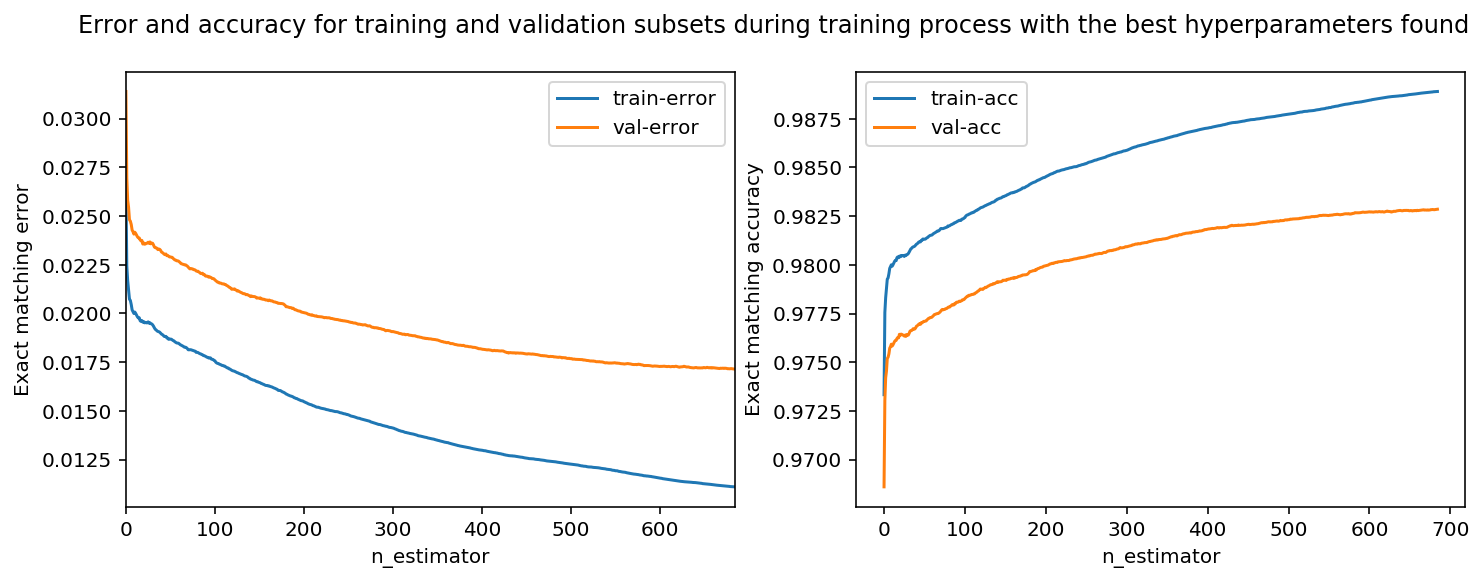

In [5]:
plt.figure(figsize=(12,4))
ax = plt.subplot(1,2,1)
cvresult['train-merror-mean'].plot(label='train-error', ax=ax)
cvresult['test-merror-mean'].plot(label='val-error', ax=ax)
plt.xlabel('n_estimator')
plt.ylabel('Exact matching error')
plt.legend()

ax = plt.subplot(1,2,2)
ax.plot(1-cvresult['train-merror-mean'], label='train-acc')
ax.plot(1-cvresult['test-merror-mean'], label='val-acc')
plt.xlabel('n_estimator')
plt.ylabel('Exact matching accuracy')
plt.suptitle("Error and accuracy for training and validation subsets during training process with the best hyperparameters found")
plt.legend();

In [6]:
bestModel.fit(trainValDf, Y_train_val, verbose=20)
testpred = bestModel.predict(testDf)
testscore = accuracy_score(Y_test, testpred)
print("Accuracy on test:", testscore)

Accuracy on test: 0.9832453275398184


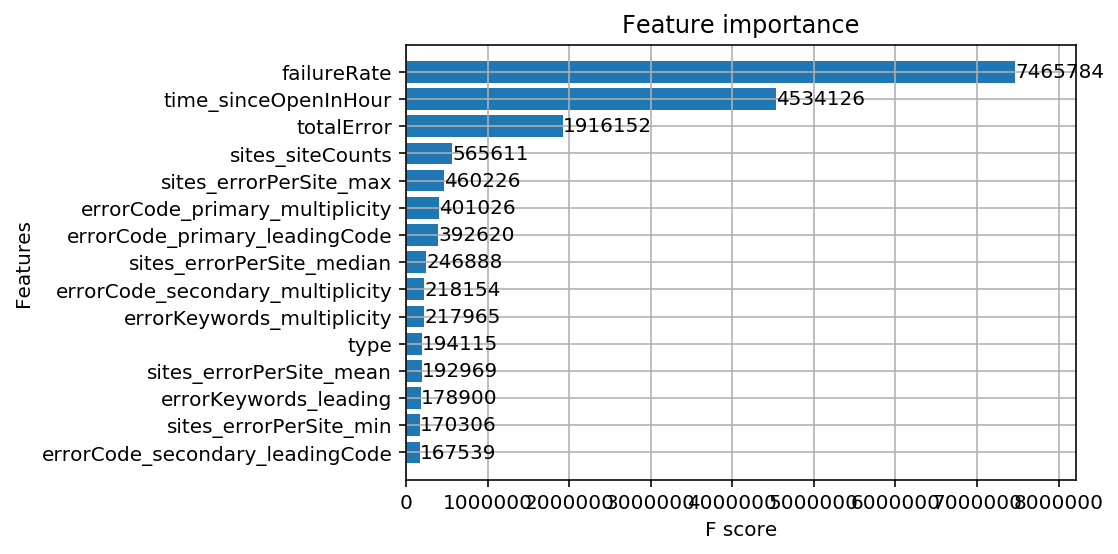

In [7]:
bst2 = bestModel.get_booster()
bst2.save_model('xgb_optimized.model')

xgb.plot_importance(bst2, height=0.8)

In [9]:
testworkflows = {i: df.query(f'label=={i}').iloc[0]['name'] for i in range(3)}
for k, v in testworkflows.items(): print(k, v)

for k, wfname in testworkflows.items():
    
    print(f'### {k} - {wfname} ###')
    
    testd = df[df['name']==wfname]
    testX, testy = testd[feature_cols], testd['label']
    testXxg = xgb.DMatrix(testX)
    test_pred_prob = bst2.predict(testXxg).reshape(testy.shape[0], 3)
    test_pred_label= np.argmax(test_pred_prob, axis=1)

    print('true:', testy.values.astype(int))
    print('predict:', test_pred_label)
    print('precision:', '{}/{}'.format((testy.values==test_pred_label).sum(), len(test_pred_label)))
    
    timespan = testd['time_sinceOpenInHour']
    timespan.values.sort()
    print('timespan:', timespan.min(), '-', timespan.max())
    
    print('_'*79, end='\n\n')

0 pdmvserv_task_HIG-RunIIFall17wmLHEGS-03920__v1_T_190516_084611_9112
1 pdmvserv_task_EXO-RunIISummer15wmLHEGS-07026__v1_T_190611_225231_6189
2 pdmvserv_task_HIG-RunIIFall17wmLHEGS-03804__v1_T_190516_002026_8689
### 0 - pdmvserv_task_HIG-RunIIFall17wmLHEGS-03920__v1_T_190516_084611_9112 ###
true: [0 0 0 ... 0 0 0]
predict: [0 0 0 ... 0 0 0]
precision: 1309/1310
timespan: 67.575 - 1257.4252777777776
_______________________________________________________________________________

### 1 - pdmvserv_task_EXO-RunIISummer15wmLHEGS-07026__v1_T_190611_225231_6189 ###
true: [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1